# Introdução à Aprendizagem de Máquina - Trabalho Final

## 1. A base de dados "A Large Scale Fish Dataset"

In [68]:
import kaggle
import pathlib

In [70]:
wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
# kaggle.api.dataset_download_files('crowww/a-large-scale-fish-dataset', path=wd+'/dataset/a-large-scale-fish-dataset', unzip=True)
kaggle.api.dataset_download_files('alxmamaev/flowers-recognition', path=wd+'/dataset/flowers-recognition', unzip=True)
# kaggle.api.dataset_download_files('moltean/fruits', path=wd+'/dataset/fruits', unzip=True)

# 2. Imports

## 2.1. Bibliotecas

In [163]:
import argparse
import cv2
import imutils
import kaggle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import pandas as pd
import pathlib
import tensorflow as tf

from IPython.display import Image, display
from PIL import Image as PILImage
from imutils import paths
from pathlib import Path
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## 2.2. Base de Dados

In [3]:
wd = pathlib.Path().absolute().as_posix()

kaggle.api.authenticate()
kaggle.api.dataset_download_files('alxmamaev/flowers-recognition', path=wd+'/dataset/flowers-recognition', unzip=True)

In [211]:
image_dir = Path('dataset/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(5)

,Filepath,Label
0,dataset/flowers-recognition/flowers/daisy/1000...,daisy
1,dataset/flowers-recognition/flowers/daisy/1014...,daisy
2,dataset/flowers-recognition/flowers/daisy/1017...,daisy
3,dataset/flowers-recognition/flowers/daisy/1017...,daisy
4,dataset/flowers-recognition/flowers/daisy/1017...,daisy


## 3. Aplicando SVM ao dataset "flowers-recognition"

In [200]:
# # Activate this code to use only 100 pictures for each label
# lst = []
# for l in image_df['Label'].unique():
#     lst.append(image_df[image_df['Label'] == l] .sample(1000, random_state = 0))
# # Concatenate the DataFrames
# image_df = pd.concat(lst)

In [212]:
len(image_df)

8646

In [213]:
image_df.Label

0       daisy
1       daisy
2       daisy
3       daisy
4       daisy
        ...  
8641    tulip
8642    tulip
8643    tulip
8644    tulip
8645    tulip
Name: Label, Length: 8646, dtype: object

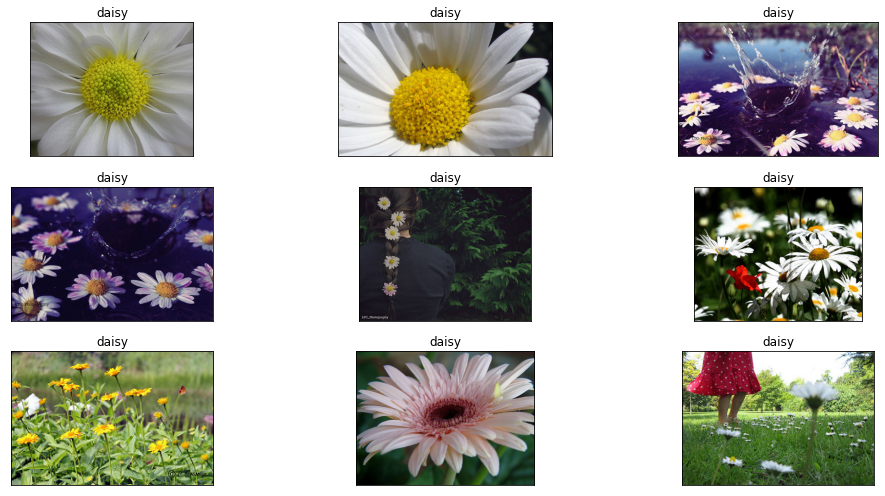

In [214]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(list(image_df['Filepath'])[i]))
    ax.set_title(list(image_df.Label)[i])
plt.tight_layout()
plt.show()

In [204]:
IMG_SIZE = 32

def get_image(filename):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    # img = PILImage.open(filename)

    # Z = skimage.transform.resize(F,
        #                            (480,380),
        #                            mode='edge',
        #                            anti_aliasing=False,
        #                            anti_aliasing_sigma=None,
        #                            preserve_range=True,
        #                            order=0)

    img_arr = cv2.imread(filename, cv2.IMREAD_COLOR)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    
    return np.array(resized_arr)

def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    gray_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.Filepath:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix_ = np.array(features_list)
    return feature_matrix_

In [215]:
feature_matrix_svm = create_feature_matrix(image_df)

In [216]:
feature_matrix_svm.shape

(8646, 3072)

In [217]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix_svm.shape)

# # define standard scaler
ss = StandardScaler()
# run this on our feature matrix
flower_stand = ss.fit_transform(feature_matrix_svm)

pca = PCA(n_components=1000)
# use fit_transform to run PCA on our standardized matrix
flower_pca = ss.fit_transform(flower_stand)
# look at new shape
print('PCA matrix shape is: ', flower_pca.shape)

Feature matrix shape is:  (8646, 3072)
PCA matrix shape is:  (8646, 3072)


In [218]:
X = pd.DataFrame(flower_pca)
y = pd.Series(image_df.Label.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

dandelion    1655
tulip        1573
daisy        1263
rose         1239
sunflower    1186
dtype: int64

In [219]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)
classifier = OneVsRestClassifier(svm)
# fit model
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=42))

In [220]:
# generate predictions
y_pred = classifier.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.8647398843930636


In [221]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       daisy       0.81      0.83      0.82       275
   dandelion       0.86      0.89      0.88       449
        rose       0.86      0.82      0.84       329
   sunflower       0.92      0.84      0.88       282
       tulip       0.88      0.91      0.90       395

    accuracy                           0.86      1730
   macro avg       0.86      0.86      0.86      1730
weighted avg       0.87      0.86      0.86      1730



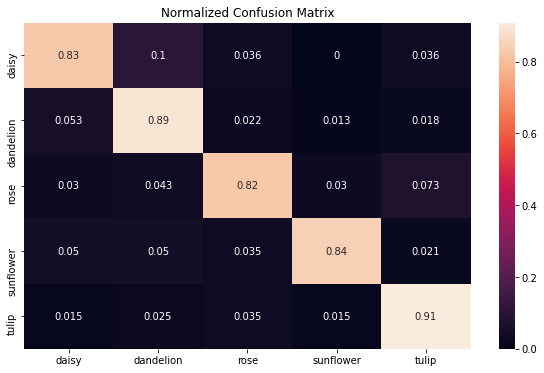

In [223]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## 4.Aplicando KNN ao dataset "flowers-recognition"

In [76]:
# Activate this code to use only 100 pictures for each label
lst = []
for l in image_df['Label'].unique():
    lst.append(image_df[image_df['Label'] == l] .sample(1000, random_state = 0))
# Concatenate the DataFrames
image_df_sample = pd.concat(lst)

In [77]:
# Shuffle the DataFrame and reset index
image_df_sample = image_df_sample.sample(frac=1).reset_index(drop = True)

# Show the result
image_df_sample.head(3)

,Filepath,Label
0,dataset/flowers-recognition/flowers/flowers/da...,daisy
1,dataset/flowers-recognition/flowers/tulip/5717...,tulip
2,dataset/flowers-recognition/flowers/flowers/tu...,tulip


In [83]:
image_df_sample = image_df

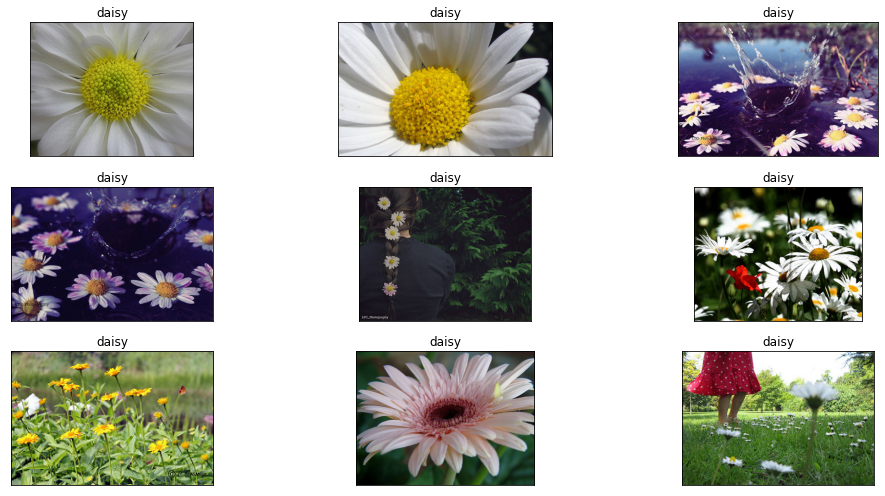

In [85]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df_sample.Filepath[i]))
    ax.set_title(image_df_sample.Label[i])
plt.tight_layout()
plt.show()

In [86]:
def image_to_feature_vector(image, size=(32, 32)):
	return cv2.resize(image, size).flatten()

In [87]:
def extract_color_histogram(image, bins=(8, 8, 8)):
	# extract a 3D color histogram from the HSV color space using
	# the supplied number of `bins` per channel
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 180, 0, 256, 0, 256])
	# handle normalizing the histogram if we are using OpenCV 2.4.X
	if imutils.is_cv2():
		hist = cv2.normalize(hist)
	# otherwise, perform "in place" normalization in OpenCV 3 (I
	# personally hate the way this is done
	else:
		cv2.normalize(hist, hist)
	# return the flattened histogram as the feature vector
	return hist.flatten()

In [88]:
# grab the list of images that we'll be describing
imagePaths = list(image_df_sample['Filepath'])
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []

In [89]:
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
	# load the image and extract the class label (assuming that our
	# path as the format: /path/to/dataset/{class}.{image_num}.jpg
	image = cv2.imread(imagePath)
	label = [image_df_sample['Label'][i]]
	# extract raw pixel intensity "features", followed by a color
	# histogram to characterize the color distribution of the pixels
	# in the image
	pixels = image_to_feature_vector(image)
	# update the raw images, features, and labels matricies,
	# respectively
	rawImages.append(pixels)
	labels.append(label)
	# show an update every 1,000 images
	if i > 0 and i % 1000 == 0:
		print("[INFO] processed {}/{}".format(i, len(imagePaths)))

[INFO] processed 100/8646
[INFO] processed 200/8646
[INFO] processed 300/8646
[INFO] processed 400/8646
[INFO] processed 500/8646
[INFO] processed 600/8646
[INFO] processed 700/8646
[INFO] processed 800/8646
[INFO] processed 900/8646
[INFO] processed 1000/8646
[INFO] processed 1100/8646
[INFO] processed 1200/8646
[INFO] processed 1300/8646
[INFO] processed 1400/8646
[INFO] processed 1500/8646
[INFO] processed 1600/8646
[INFO] processed 1700/8646
[INFO] processed 1800/8646
[INFO] processed 1900/8646
[INFO] processed 2000/8646
[INFO] processed 2100/8646
[INFO] processed 2200/8646
[INFO] processed 2300/8646
[INFO] processed 2400/8646
[INFO] processed 2500/8646
[INFO] processed 2600/8646
[INFO] processed 2700/8646
[INFO] processed 2800/8646
[INFO] processed 2900/8646
[INFO] processed 3000/8646
[INFO] processed 3100/8646
[INFO] processed 3200/8646
[INFO] processed 3300/8646
[INFO] processed 3400/8646
[INFO] processed 3500/8646
[INFO] processed 3600/8646
[INFO] processed 3700/8646
[INFO] pro

In [111]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
rawImages = np.array(rawImages)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 25.94MB
[INFO] features matrix: 17.29MB


In [112]:
(X_train, X_test, y_train, y_test) = train_test_split(
	rawImages, labels, test_size=0.20, random_state=42)

In [130]:
# train and evaluate a k-NN classifer on the raw pixel intensities
knn = KNeighborsClassifier(n_neighbors=1)
classifier = OneVsRestClassifier(knn, n_jobs=-1)
classifier.fit(X_train,y_train)
acc = classifier.score(X_test, np.array(y_test))
print("Raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 86.36%


In [114]:
pred = classifier.predict(X_test)

In [115]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.91      0.80      0.85       313
   dandelion       0.75      0.94      0.83       435
        rose       0.88      0.86      0.87       320
   sunflower       0.96      0.89      0.92       289
       tulip       0.93      0.81      0.86       373

    accuracy                           0.86      1730
   macro avg       0.88      0.86      0.87      1730
weighted avg       0.88      0.86      0.86      1730



In [104]:
set(y_test.flatten())

{'daisy', 'dandelion', 'rose', 'sunflower', 'tulip'}

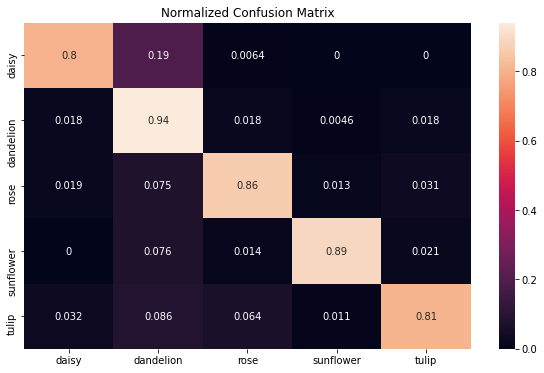

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test.flatten())), yticklabels = sorted(set(y_test.flatten())))
plt.title('Normalized Confusion Matrix')
plt.show()

## 3. Aplicando a implementação original ao dataset "flowers-recognition"

In [99]:
image_dir = Path('dataset/flowers-recognition/flowers')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,dataset/flowers-recognition/flowers/daisy/1000...,daisy
1,dataset/flowers-recognition/flowers/daisy/1014...,daisy
2,dataset/flowers-recognition/flowers/daisy/1017...,daisy
3,dataset/flowers-recognition/flowers/daisy/1017...,daisy
4,dataset/flowers-recognition/flowers/daisy/1017...,daisy
...,...,...
8641,dataset/flowers-recognition/flowers/tulip/9831...,tulip
8642,dataset/flowers-recognition/flowers/tulip/9870...,tulip
8643,dataset/flowers-recognition/flowers/tulip/9947...,tulip
8644,dataset/flowers-recognition/flowers/tulip/9947...,tulip


In [100]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,dataset/flowers-recognition/flowers/tulip/1427...,tulip
1,dataset/flowers-recognition/flowers/flowers/da...,daisy
2,dataset/flowers-recognition/flowers/dandelion/...,dandelion


In [111]:
import cv2

In [115]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [142]:
IMG_SIZE = 224
resized = []
for path in image_df['Filepath']:
    img_arr = cv2.imread(path, cv2.IMREAD_COLOR)
    resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    resized.append([resized_arr])

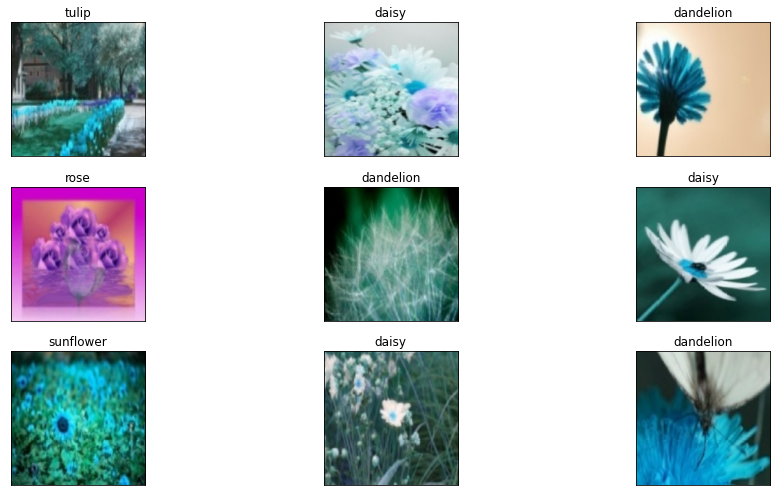

In [143]:
# Display 9 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(resized[i][0])
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [144]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [145]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [146]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6225 validated image filenames belonging to 5 classes.
Found 1556 validated image filenames belonging to 5 classes.
Found 865 validated image filenames belonging to 5 classes.


In [147]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [149]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # 5 is the number of labels

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
195/195 [==============================] - 236s 1s/step - loss: 0.7417 - accuracy: 0.7221 - val_loss: 0.3495 - val_accuracy: 0.8734
Epoch 2/50
195/195 [==============================] - 120s 613ms/step - loss: 0.2836 - accuracy: 0.9036 - val_loss: 0.2636 - val_accuracy: 0.9120
Epoch 3/50
195/195 [==============================] - 110s 564ms/step - loss: 0.1550 - accuracy: 0.9496 - val_loss: 0.2423 - val_accuracy: 0.9248
Epoch 4/50
195/195 [==============================] - 122s 626ms/step - loss: 0.0929 - accuracy: 0.9729 - val_loss: 0.1754 - val_accuracy: 0.9473
Epoch 5/50
195/195 [==============================] - 113s 577ms/step - loss: 0.0441 - accuracy: 0.9868 - val_loss: 0.1747 - val_accuracy: 0.9557
Epoch 6/50
195/195 [==============================] - 109s 559ms/step - loss: 0.0390 - accuracy: 0.9887 - val_loss: 0.1834 - val_accuracy: 0.9589
Epoch 7/50
195/195 [==============================] - 107s 547ms/step - loss: 0.0143 - accuracy: 0.9975 - val_loss: 0.2247 - va

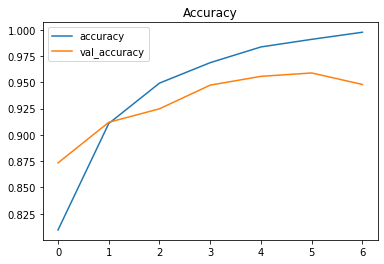

In [150]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

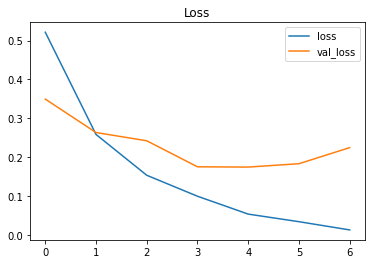

In [151]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [152]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.13353
Test Accuracy: 95.84%


In [153]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['dandelion', 'sunflower', 'tulip', 'sunflower', 'daisy']


In [154]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

       daisy       0.94      0.97      0.95       157
   dandelion       0.96      0.95      0.96       192
        rose       0.94      0.96      0.95       165
   sunflower       0.98      0.97      0.97       148
       tulip       0.97      0.95      0.96       203

    accuracy                           0.96       865
   macro avg       0.96      0.96      0.96       865
weighted avg       0.96      0.96      0.96       865



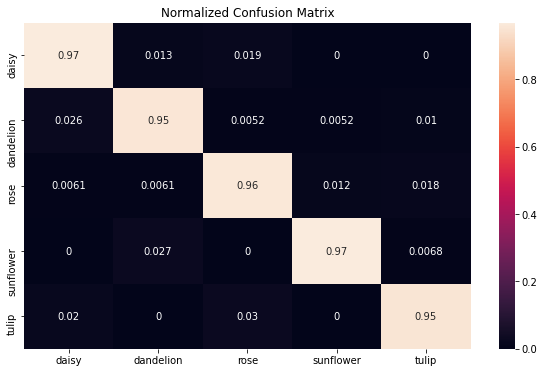

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## 6. Comparando os resultados

## 7. Referências

- O.Ulucan , D.Karakaya and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification. In Conf. Innovations Intell. Syst. Appli. (ASYU)
- Huang, G., Liu, Z., Weinberger, K. Q., & van der Maaten, L. (2016). Densely connected convolutional networks. arXiv preprint arXiv:1608.06993.
- Huang, G., Sun, Y., Liu, Z., Sedra, D., & Weinberger, K. Q. (2016). Deep networks with stochastic depth. In European Conference on Computer Vision (ECCV '16)
- https://www.kaggle.com/alxmamaev/flowers-recognition - Alexander Mamaev
- https://www.pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification
- https://www.pyimagesearch.com/2016/08/15/how-to-tune-hyperparameters-with-python-and-scikit-learn/
- https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification